In [2]:
from msclap import CLAP
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [27]:
df= pd.read_csv('/work/data_cloud/speech_enhancement/eval_data/real_world/subjective/subjective_testset_48k/BST_2022_48k/BST_DN/meta_bstdn_v3.csv')

df['age_group'].unique()
df['class'] = np.where(df['age_group'] == 'adult', df['gender'], 'child')
df['filename'] = '/work/data_cloud/speech_enhancement/eval_data/real_world/subjective/subjective_testset_48k/BST_2022_48k/BST_DN/BST_DN_v3_input_files/' + df['filename']

df = df[['filename', 'class']]
df=df.sort_values('class')
display(df)


,filename,class
136,/work/data_cloud/speech_enhancement/eval_data/...,child
82,/work/data_cloud/speech_enhancement/eval_data/...,child
81,/work/data_cloud/speech_enhancement/eval_data/...,child
65,/work/data_cloud/speech_enhancement/eval_data/...,child
111,/work/data_cloud/speech_enhancement/eval_data/...,child
...,...,...
99,/work/data_cloud/speech_enhancement/eval_data/...,male
100,/work/data_cloud/speech_enhancement/eval_data/...,male
102,/work/data_cloud/speech_enhancement/eval_data/...,male
106,/work/data_cloud/speech_enhancement/eval_data/...,male


In [28]:
classes = df['class'].unique()

class_id_map = {name: i for i, name in enumerate(classes, 0)}
print(class_id_map)

prompt = 'The speaker is aa:'
y = [prompt + x for x in classes]


{'child': 0, 'female': 1, 'male': 2}


In [29]:
# Load and initialize CLAP
clap_model = CLAP(version = '2023', use_cuda=True)

# Computing text embeddings
text_embeddings = clap_model.get_text_embeddings(y)

In [30]:
# Computing audio embeddings
y_preds, y_labels = [], []
print(os.getcwd())

for i in tqdm(range(len(df))):
    path, label = df.iloc[i]
    idx = class_id_map[label]
    #print(idx)
    one_hot_target = torch.nn.functional.one_hot(torch.tensor([idx]), num_classes=len(classes)+1)

    audio_embeddings = clap_model.get_audio_embeddings([path], resample=True)
    similarity = clap_model.compute_similarity(audio_embeddings, text_embeddings)

    y_pred = F.softmax(similarity.detach().cpu(), dim=1).numpy()

    y_preds.append(y_pred)
    y_labels.append(one_hot_target.detach().cpu().numpy())


/mounts/ud-data/jtaylor/a5f2c23d-7fb6-41a6-ac0c-3a2ffc02b992/data/acoustic_scene_classification/CLAP-main/examples/child_speech_classification


100%|██████████| 210/210 [00:24<00:00,  8.70it/s]


In [31]:
y_lab, y_pred = np.concatenate(y_labels, axis=0), np.concatenate(y_preds, axis=0)
y_label_val = np.argmax(y_lab, axis=1)
y_pred_val = np.argmax(y_pred, axis=1)
acc = accuracy_score(np.argmax(y_lab, axis=1), np.argmax(y_pred, axis=1))
print('Accuracy {}'.format(acc))

Accuracy 0.8666666666666667


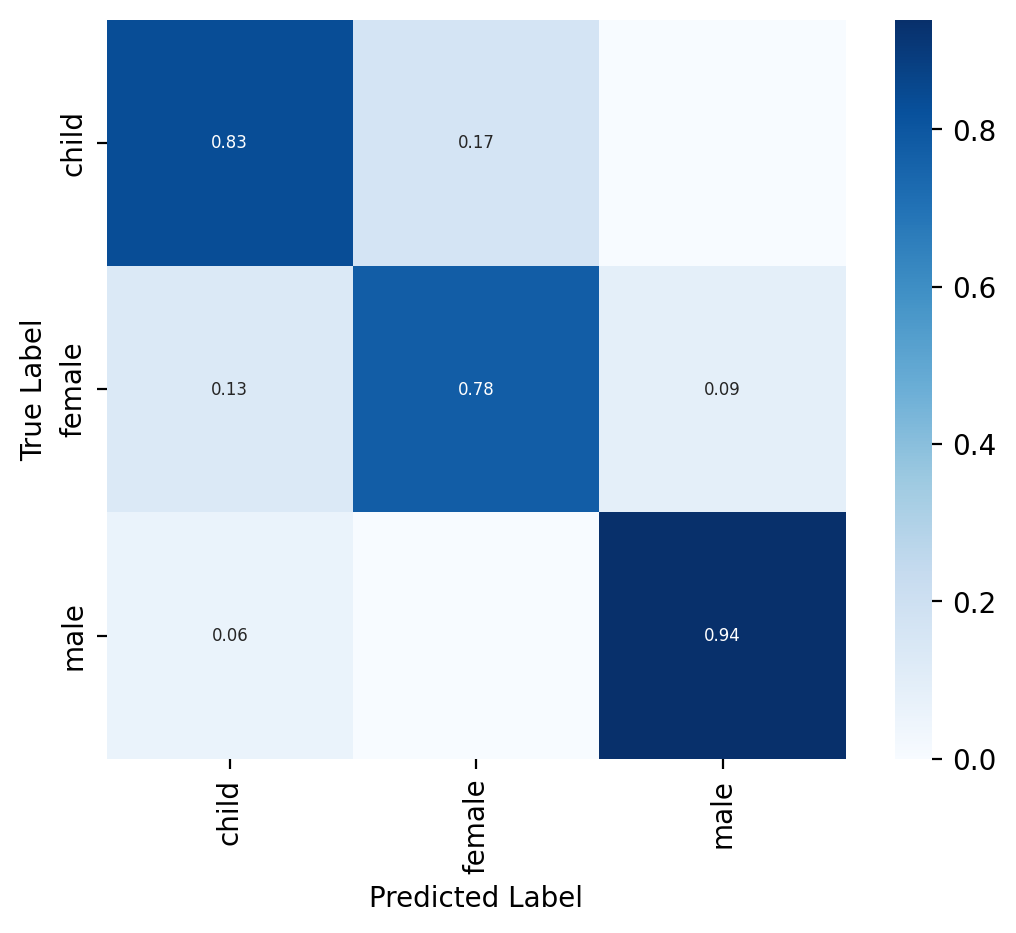

In [32]:
# get confusion matrix
conf_matrix = confusion_matrix(y_label_val,y_pred_val)
conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
mean_recall = np.mean(recall_by_class)

# Calculate row sums to use for percentages
row_sums = conf_matrix.sum(axis=1)

# Calculate percentages
percentages = (conf_matrix.T / row_sums).T  # Transpose for division, then transpose back

# Format percentages as strings with '%' symbol
annot_data = [['{:.2f}'.format(val) for val in row] for row in percentages]
annot_data = [['' if float(val <= 0.04) else '{:.2f}'.format(val) for val in row] for row in percentages]

plt.figure(dpi=200)

annot_kws = {'size': 6}
ax = sns.heatmap(percentages, xticklabels=classes, yticklabels=classes, annot=annot_data, fmt='', square=True, cmap='Blues', annot_kws=annot_kws)
ax.set_xlabel('Predicted Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_ylabel('True Label')

#plt.subplots_adjust(left=0.2, bottom=0.35)
plt.show()